In [1]:
!pip install neuralforecast

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.8/141.8 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.0/719.0 kB 23.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.6/58.6 MB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 51.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.5/468.5 kB 22.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from neuralforecast import NeuralForecast
from neuralforecast.models import NBEATSx
from neuralforecast.losses.pytorch import MQLoss, DistributionLoss, MSE, MAE
from neuralforecast.tsdataset import TimeSeriesDataset, TimeSeriesLoader
from numpy.random import seed
from random import randrange
from neuralforecast.losses.numpy import rmse, mape
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
from neuralforecast.utils import AirPassengers, AirPassengersPanel, AirPassengersStatic

In [3]:
df = pd.read_excel("S&P BSE SENSEX (NBEATSx).xlsx",index_col='Date',parse_dates=True)


In [4]:
df.reset_index(inplace=True)
df.rename(columns={'Date':'ds'}, inplace=True)
df.rename(columns={'Realised':'y'}, inplace=True)
train = df.iloc[:int(len(df['y'])*0.7)]
test = df.iloc[int(len(df['y'])*0.7)]
validation_length=int(len(df['y'])*0.7)-int(len(df['y'])*0.6)

In [ ]:
n_inputs = [12,21,63,84,126,189,252]
mlp_units = [[[712, 712], [712, 712]],[[512, 512], [512, 512]],[[250, 250], [250, 250]],[[100, 100], [100, 100]]]
epochs = [100,150,200]
learning_rate=[0.05,0.005,0.0005,0.0001]
num_lr_decays=[10,5,3,5]
dropouts=[0,0.2,0.4]
scaler_type=["robust","standard",'minmax']
stack_types=[['identity','identity'],['trend','identity'],['seasonality','identity'],['trend','seasonality']]
n_harmonics=[0,0,1,1]
n_polynomials=[0,1,0,1]
losses=[MSE(),MAE(),MQLoss(level=[80, 90]),DistributionLoss(distribution='StudentT', level=[80, 90])]
RMSE = []
Accuracy = []

# Hyperparameter Search

In [ ]:
for m in range (5):
  i=randrange(6)
  h=randrange(4)
  k=randrange(3)
  l=randrange(4)
  m=randrange(4)
  n=randrange(4)
  o=randrange(3)
  model = NBEATSx(h=1, input_size=n_inputs[i],
                loss=losses[m],
                scaler_type=scaler_type[o],
                learning_rate=learning_rate[n],
                stack_types=stack_types[l],
                n_blocks=[1, 1],
                mlp_units=mlp_units[h],
                windows_batch_size=64,
                num_lr_decays=num_lr_decays[n],
                val_check_steps=500,
                n_harmonics=n_harmonics[l], n_polynomials=n_polynomials[l],
                hist_exog_list=['VIX'],
                max_steps=epochs[k],
                random_seed=randrange(129228148))
  fcst = NeuralForecast(models=[model],freq=CustomBusinessDay(calendar=USFederalHolidayCalendar()))
  forecasts = fcst.cross_validation(df=train,val_size=10,static_df=AirPassengersStatic,n_windows=None, test_size=validation_length,step_size=1)
  forecasts = forecasts.dropna()
  if "NBEATSx-median" not in list(forecasts.columns.values):
    Y_hat=forecasts["NBEATSx"].values
  else:
    Y_hat=forecasts["NBEATSx-median"].values
  Y_true=forecasts["y"].values
  RMSE=np.sum(np.sqrt((Y_true-Y_hat)**2))/len(Y_true)
  Accuracy=(1-np.sum(np.sqrt((Y_true-Y_hat)**2)/Y_true)/(len(Y_true)))*100
  print(f"Epoch: {epochs[k]} | Inputs: {n_inputs[i]} | MLP units: {mlp_units[h]} | Loss: {losses[m]} | Scaler Type: {scaler_type[o]}")
  print(f"Stack Types: {stack_types[l]} | Learning Rate: {learning_rate[n]}")
  print(f"RMSE: {RMSE} | Accuracy: {Accuracy}")

INFO:lightning_fabric.utilities.seed:Global seed set to 4548822


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 18085809


Epoch: 100 | Inputs: 84 | MLP units: [[250, 250], [250, 250]] | Loss: MQLoss() | Scaler Type: standard
Stack Types: ['seasonality', 'identity'] | Learning Rate: 0.05
RMSE: 0.05263170104961112 | Accuracy: -675.6509471642067


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 59976268


Epoch: 100 | Inputs: 63 | MLP units: [[250, 250], [250, 250]] | Loss: MSE() | Scaler Type: robust
Stack Types: ['identity', 'identity'] | Learning Rate: 0.0005
RMSE: 0.0030965760288382245 | Accuracy: 56.92035257829098


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 5341169


Epoch: 100 | Inputs: 12 | MLP units: [[712, 712], [712, 712]] | Loss: MQLoss() | Scaler Type: standard
Stack Types: ['trend', 'identity'] | Learning Rate: 0.005
RMSE: 0.002663672600747538 | Accuracy: 65.46842736580886


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 25307138


Epoch: 100 | Inputs: 189 | MLP units: [[250, 250], [250, 250]] | Loss: MQLoss() | Scaler Type: robust
Stack Types: ['trend', 'seasonality'] | Learning Rate: 0.0001
RMSE: 0.0033927062507196765 | Accuracy: 56.46315762025817


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Epoch: 100 | Inputs: 84 | MLP units: [[100, 100], [100, 100]] | Loss: MSE() | Scaler Type: standard
Stack Types: ['seasonality', 'identity'] | Learning Rate: 0.05
RMSE: 0.04288178444927213 | Accuracy: -546.7274772900379


In [ ]:
for m in range (5):
  i=randrange(6)
  h=randrange(4)
  k=randrange(3)
  l=randrange(4)
  m=randrange(4)
  n=randrange(4)
  o=randrange(3)
  model = NBEATSx(h=1, input_size=n_inputs[i],
                loss=losses[m],
                scaler_type=scaler_type[o],
                learning_rate=learning_rate[n],
                stack_types=stack_types[l],
                n_blocks=[1, 1],
                mlp_units=mlp_units[h],
                windows_batch_size=64,
                num_lr_decays=num_lr_decays[n],
                val_check_steps=500,
                n_harmonics=n_harmonics[l], n_polynomials=n_polynomials[l],
                hist_exog_list=['VIX'],
                max_steps=epochs[k],
                random_seed=randrange(129228148))
  fcst = NeuralForecast(models=[model],freq=CustomBusinessDay(calendar=USFederalHolidayCalendar()))
  forecasts = fcst.cross_validation(df=train,val_size=10,static_df=AirPassengersStatic,n_windows=None, test_size=validation_length,step_size=1)
  forecasts = forecasts.dropna()
  if "NBEATSx-median" not in list(forecasts.columns.values):
    Y_hat=forecasts["NBEATSx"].values
  else:
    Y_hat=forecasts["NBEATSx-median"].values
  Y_true=forecasts["y"].values
  RMSE=np.sum(np.sqrt((Y_true-Y_hat)**2))/len(Y_true)
  Accuracy=(1-np.sum(np.sqrt((Y_true-Y_hat)**2)/Y_true)/(len(Y_true)))*100
  print(f"Epoch: {epochs[k]} | Inputs: {n_inputs[i]} | MLP units: {mlp_units[h]} | Loss: {losses[m]} | Scaler Type: {scaler_type[o]}")
  print(f"Stack Types: {stack_types[l]} | Learning Rate: {learning_rate[n]}")
  print(f"RMSE: {RMSE} | Accuracy: {Accuracy}")

INFO:lightning_fabric.utilities.seed:Global seed set to 84286804


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 17361163


Epoch: 200 | Inputs: 63 | MLP units: [[100, 100], [100, 100]] | Loss: MSE() | Scaler Type: standard
Stack Types: ['seasonality', 'identity'] | Learning Rate: 0.0001
RMSE: 0.003350049036558359 | Accuracy: 56.51071051773824


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 105938013


Epoch: 150 | Inputs: 126 | MLP units: [[712, 712], [712, 712]] | Loss: MSE() | Scaler Type: standard
Stack Types: ['trend', 'identity'] | Learning Rate: 0.005
RMSE: 0.0034112344383875393 | Accuracy: 55.10156237295008


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 101390958


Epoch: 150 | Inputs: 126 | MLP units: [[512, 512], [512, 512]] | Loss: MQLoss() | Scaler Type: minmax
Stack Types: ['identity', 'identity'] | Learning Rate: 0.05
RMSE: 0.1984298383329198 | Accuracy: -2804.19882042914


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 17442083


Epoch: 100 | Inputs: 21 | MLP units: [[512, 512], [512, 512]] | Loss: MAE() | Scaler Type: minmax
Stack Types: ['seasonality', 'identity'] | Learning Rate: 0.0001
RMSE: 0.0028443376521584455 | Accuracy: 64.07994073220198


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Epoch: 200 | Inputs: 63 | MLP units: [[512, 512], [512, 512]] | Loss: MQLoss() | Scaler Type: standard
Stack Types: ['trend', 'identity'] | Learning Rate: 0.0005
RMSE: 0.0026007377958447747 | Accuracy: 66.32436233857581


In [ ]:
for m in range (5):
  i=randrange(6)
  h=randrange(4)
  k=randrange(3)
  l=randrange(4)
  m=randrange(4)
  n=randrange(4)
  o=randrange(3)
  model = NBEATSx(h=1, input_size=n_inputs[i],
                loss=losses[m],
                scaler_type=scaler_type[o],
                learning_rate=learning_rate[n],
                stack_types=stack_types[l],
                n_blocks=[1, 1],
                mlp_units=mlp_units[h],
                windows_batch_size=64,
                num_lr_decays=num_lr_decays[n],
                val_check_steps=500,
                n_harmonics=n_harmonics[l], n_polynomials=n_polynomials[l],
                hist_exog_list=['VIX'],
                max_steps=epochs[k],
                random_seed=randrange(129228148))
  fcst = NeuralForecast(models=[model],freq=CustomBusinessDay(calendar=USFederalHolidayCalendar()))
  forecasts = fcst.cross_validation(df=train,val_size=10,static_df=AirPassengersStatic,n_windows=None, test_size=validation_length,step_size=1)
  forecasts = forecasts.dropna()
  if "NBEATSx-median" not in list(forecasts.columns.values):
    Y_hat=forecasts["NBEATSx"].values
  else:
    Y_hat=forecasts["NBEATSx-median"].values
  Y_true=forecasts["y"].values
  RMSE=np.sum(np.sqrt((Y_true-Y_hat)**2))/len(Y_true)
  Accuracy=(1-np.sum(np.sqrt((Y_true-Y_hat)**2)/Y_true)/(len(Y_true)))*100
  print(f"Epoch: {epochs[k]} | Inputs: {n_inputs[i]} | MLP units: {mlp_units[h]} | Loss: {losses[m]} | Scaler Type: {scaler_type[o]}")
  print(f"Stack Types: {stack_types[l]} | Learning Rate: {learning_rate[n]}")
  print(f"RMSE: {RMSE} | Accuracy: {Accuracy}")

INFO:lightning_fabric.utilities.seed:Global seed set to 103030997


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 4164162


Epoch: 100 | Inputs: 63 | MLP units: [[512, 512], [512, 512]] | Loss: DistributionLoss() | Scaler Type: minmax
Stack Types: ['trend', 'identity'] | Learning Rate: 0.0005
RMSE: 0.002984342748585892 | Accuracy: 60.33715551702101


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 114811706


Epoch: 150 | Inputs: 12 | MLP units: [[100, 100], [100, 100]] | Loss: MSE() | Scaler Type: minmax
Stack Types: ['trend', 'seasonality'] | Learning Rate: 0.0005
RMSE: 0.002662316149872257 | Accuracy: 64.99006740572825


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 62965060


Epoch: 150 | Inputs: 189 | MLP units: [[250, 250], [250, 250]] | Loss: MAE() | Scaler Type: robust
Stack Types: ['trend', 'identity'] | Learning Rate: 0.005
RMSE: 0.0031281262061516064 | Accuracy: 59.172769916015014


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 109547553


Epoch: 100 | Inputs: 12 | MLP units: [[250, 250], [250, 250]] | Loss: DistributionLoss() | Scaler Type: minmax
Stack Types: ['trend', 'seasonality'] | Learning Rate: 0.0001
RMSE: 0.0032352729699024075 | Accuracy: 57.48508125212191


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Epoch: 150 | Inputs: 21 | MLP units: [[512, 512], [512, 512]] | Loss: DistributionLoss() | Scaler Type: standard
Stack Types: ['seasonality', 'identity'] | Learning Rate: 0.05
RMSE: 24127.568810195673 | Accuracy: -343943816.2935335


In [ ]:
for m in range (5):
  i=randrange(6)
  h=randrange(4)
  k=randrange(3)
  l=randrange(4)
  m=randrange(4)
  n=randrange(4)
  o=randrange(3)
  model = NBEATSx(h=1, input_size=n_inputs[i],
                loss=losses[m],
                scaler_type=scaler_type[o],
                learning_rate=learning_rate[n],
                stack_types=stack_types[l],
                n_blocks=[1, 1],
                mlp_units=mlp_units[h],
                windows_batch_size=64,
                num_lr_decays=num_lr_decays[n],
                val_check_steps=500,
                n_harmonics=n_harmonics[l], n_polynomials=n_polynomials[l],
                hist_exog_list=['VIX'],
                max_steps=epochs[k],
                random_seed=randrange(129228148))
  fcst = NeuralForecast(models=[model],freq=CustomBusinessDay(calendar=USFederalHolidayCalendar()))
  forecasts = fcst.cross_validation(df=train,val_size=10,static_df=AirPassengersStatic,n_windows=None, test_size=validation_length,step_size=1)
  forecasts = forecasts.dropna()
  if "NBEATSx-median" not in list(forecasts.columns.values):
    Y_hat=forecasts["NBEATSx"].values
  else:
    Y_hat=forecasts["NBEATSx-median"].values
  Y_true=forecasts["y"].values
  RMSE=np.sum(np.sqrt((Y_true-Y_hat)**2))/len(Y_true)
  Accuracy=(1-np.sum(np.sqrt((Y_true-Y_hat)**2)/Y_true)/(len(Y_true)))*100
  print(f"Epoch: {epochs[k]} | Inputs: {n_inputs[i]} | MLP units: {mlp_units[h]} | Loss: {losses[m]} | Scaler Type: {scaler_type[o]}")
  print(f"Stack Types: {stack_types[l]} | Learning Rate: {learning_rate[n]}")
  print(f"RMSE: {RMSE} | Accuracy: {Accuracy}")

INFO:lightning_fabric.utilities.seed:Global seed set to 73027507


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 87568563


Epoch: 150 | Inputs: 63 | MLP units: [[512, 512], [512, 512]] | Loss: MQLoss() | Scaler Type: minmax
Stack Types: ['trend', 'identity'] | Learning Rate: 0.0005
RMSE: 0.002669989021813897 | Accuracy: 65.79875323357967


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 63875363


Epoch: 100 | Inputs: 189 | MLP units: [[100, 100], [100, 100]] | Loss: MSE() | Scaler Type: robust
Stack Types: ['trend', 'identity'] | Learning Rate: 0.0005
RMSE: 0.0033337293128631097 | Accuracy: 55.93676350637733


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 33428793


Epoch: 150 | Inputs: 63 | MLP units: [[712, 712], [712, 712]] | Loss: MAE() | Scaler Type: standard
Stack Types: ['trend', 'identity'] | Learning Rate: 0.0005
RMSE: 0.002768573462907815 | Accuracy: 63.971706673669615


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 40959797


Epoch: 200 | Inputs: 189 | MLP units: [[512, 512], [512, 512]] | Loss: MSE() | Scaler Type: minmax
Stack Types: ['trend', 'identity'] | Learning Rate: 0.0005
RMSE: 0.0031070379231420996 | Accuracy: 56.646753519846804


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Epoch: 100 | Inputs: 63 | MLP units: [[512, 512], [512, 512]] | Loss: MSE() | Scaler Type: minmax
Stack Types: ['trend', 'seasonality'] | Learning Rate: 0.0005
RMSE: 0.0029762074099862353 | Accuracy: 59.586505595070975


Epoch: 200 | Inputs: 63 | MLP units: [[512, 512], [512, 512]] | Loss: MQLoss() | Scaler Type: standard
Stack Types: ['trend', 'identity'] | Learning Rate: 0.0005
RMSE: 0.0026007377958447747 | Accuracy: 66.32436233857581

# H=1 Forecasts

In [ ]:
Accuracy=[]
RMSE=[]
Quasilikelihood=[]

In [7]:
test_length=len(df["y"])-int(len(df['y'])*0.7)

In [8]:
for i in range(1):
  model = NBEATSx(h=1, input_size=63,
                  loss=MQLoss(level=[90]),
                  scaler_type='standard',
                  learning_rate= 0.0005,
                  stack_types=['trend','identity'],
                  n_blocks=[1,1],
                  mlp_units= [[512, 512], [512, 512]],
                  windows_batch_size=60,
                  num_lr_decays=5,
                  val_check_steps=100,
                  n_harmonics=0, n_polynomials=1,
                  hist_exog_list=['VIX'],
                  max_steps=200,
                  early_stop_patience_steps=1,
                  random_seed=randrange(129228148)
                  )
  fcst = NeuralForecast(models=[model],freq=CustomBusinessDay(calendar=USFederalHolidayCalendar()))
  forecasts = fcst.cross_validation(df=df,val_size=10,static_df=AirPassengersStatic,n_windows=None, test_size=test_length,step_size=1)

INFO:lightning_fabric.utilities.seed:Global seed set to 120052174


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

In [9]:
df1 = forecasts[forecasts.isna().any(axis=1)]

In [10]:
df1

unique_id         ds     cutoff  NBEATSx-median  NBEATSx-lo-90  \
34    Airline1 2016-07-06 2016-07-05        0.005468       0.002735   
62    Airline1 2016-08-15 2016-08-12        0.005035       0.002008   
82    Airline1 2016-09-13 2016-09-12        0.006375       0.003692   
101   Airline1 2016-10-11 2016-10-07        0.004288       0.001985   
102   Airline1 2016-10-12 2016-10-11        0.006066       0.003209   
...        ...        ...        ...             ...            ...   
1601  Airline1 2022-10-05 2022-10-04        0.008039       0.004039   
1615  Airline1 2022-10-26 2022-10-25        0.005545       0.001720   
1624  Airline1 2022-11-08 2022-11-07        0.007342       0.004874   
1676  Airline1 2023-01-26 2023-01-25        0.005070       0.003274   
1703  Airline1 2023-03-07 2023-03-06        0.006086       0.003240   

      NBEATSx-hi-90   y  VIX  
34         0.010716 NaN  NaN  
62         0.009701 NaN  NaN  
82         0.012622 NaN  NaN  
101        0.008552 NaN  NaN  
102        0.011458 NaN  NaN  
...             ...  ..  ...  
1601       0.015177 NaN  NaN  
1615       0.011189 NaN  NaN  
1624       0.014980 NaN  NaN  
1676       0.008660 NaN  NaN  
1703       0.011216 NaN  NaN  

[87 rows x 8 columns]

In [11]:
from pandas.tseries.offsets import CustomBusinessDay
holidays=df1['ds'].tolist()

Business_Days = CustomBusinessDay(holidays=holidays)

In [12]:
model = NBEATSx(h=1, input_size=63,
                loss=MQLoss(level=[90]),
                scaler_type='standard',
                learning_rate= 0.0005,
                stack_types=['trend','identity'],
                n_blocks=[1,1],
                mlp_units= [[512, 512], [512, 512]],
                windows_batch_size=60,
                num_lr_decays=5,
                val_check_steps=100,
                n_harmonics=0, n_polynomials=1,
                hist_exog_list=['VIX'],
                max_steps=200,
                early_stop_patience_steps=1,
                random_seed=randrange(129228148)
                )
fcst = NeuralForecast(models=[model],freq=Business_Days)
forecasts = fcst.cross_validation(df=df,val_size=10,static_df=AirPassengersStatic,n_windows=None, test_size=test_length,step_size=1)

INFO:lightning_fabric.utilities.seed:Global seed set to 15702668


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

In [13]:
df2 = forecasts[forecasts.isna().any(axis=1)]

In [14]:
df2

unique_id         ds     cutoff  NBEATSx-median  NBEATSx-lo-90  \
92    Airline1 2016-09-05 2016-09-02        0.005843       0.002203   
416   Airline1 2017-12-25 2017-12-22        0.003701       0.002252   
663   Airline1 2018-12-25 2018-12-24        0.008987       0.005070   
668   Airline1 2019-01-01 2018-12-31        0.007028       0.002452   
831   Airline1 2019-09-02 2019-08-30        0.009363       0.007291   
907   Airline1 2019-12-25 2019-12-24        0.005003       0.002636   
912   Airline1 2020-01-01 2019-12-31        0.004603       0.002105   
1008  Airline1 2020-05-25 2020-05-22        0.017969       0.002573   
1159  Airline1 2020-12-25 2020-12-24        0.010415       0.005405   

      NBEATSx-hi-90   y  VIX  
92         0.012628 NaN  NaN  
416        0.007727 NaN  NaN  
663        0.017181 NaN  NaN  
668        0.016338 NaN  NaN  
831        0.016338 NaN  NaN  
907        0.010753 NaN  NaN  
912        0.009746 NaN  NaN  
1008       0.042147 NaN  NaN  
1159       0.019302 NaN  NaN

In [15]:
df2['ds'].values

array(['2016-09-05T00:00:00.000000000', '2017-12-25T00:00:00.000000000',
       '2018-12-25T00:00:00.000000000', '2019-01-01T00:00:00.000000000',
       '2019-09-02T00:00:00.000000000', '2019-12-25T00:00:00.000000000',
       '2020-01-01T00:00:00.000000000', '2020-05-25T00:00:00.000000000',
       '2020-12-25T00:00:00.000000000'], dtype='datetime64[ns]')

In [16]:
for i in range(len(df2['ds'].values)):
  holidays.append(df2['ds'].values[i])

Business_Days = CustomBusinessDay(holidays=holidays)

In [ ]:
for i in range(15):
  model = NBEATSx(h=1, input_size=63,
                  loss=MQLoss(level=[90]),
                  scaler_type='standard',
                  learning_rate= 0.0005,
                  stack_types=['trend','identity'],
                  n_blocks=[1,1],
                  mlp_units= [[512, 512], [512, 512]],
                  windows_batch_size=60,
                  num_lr_decays=5,
                  val_check_steps=100,
                  n_harmonics=0, n_polynomials=1,
                  hist_exog_list=['VIX'],
                  max_steps=200,
                  early_stop_patience_steps=1,
                  random_seed=randrange(129228148)
                  )
  fcst = NeuralForecast(models=[model],freq=Business_Days)
  forecasts = fcst.cross_validation(df=df,val_size=10,static_df=AirPassengersStatic,n_windows=None, test_size=test_length,step_size=1)
  forecasts = forecasts.dropna()
  if "NBEATSx-median" not in list(forecasts.columns.values):
    Y_hat=forecasts["NBEATSx"].values
  else:
    Y_hat=forecasts["NBEATSx-median"].values
  Y_true=forecasts["y"].values
  RMSE.append(np.sum(np.sqrt((Y_true-Y_hat)**2))/len(Y_true))
  Accuracy.append((1-np.sum(np.sqrt((Y_true-Y_hat)**2)/Y_true)/(len(Y_true)))*100)
  Quasilikelihood.append(np.sum(Y_true/Y_hat-np.log(Y_true/Y_hat)-1)/len(Y_true))

INFO:lightning_fabric.utilities.seed:Global seed set to 125587831


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 50770203


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 123087927


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 37126113


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 49024390


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 99599478


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 34959323


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 37088695


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 102952538


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 101500905


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 54141737


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 64555193


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 124756830


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

In [ ]:
Accuracy

[70.09975748367083,
 69.95609541284786,
 70.23802708299955,
 70.17139451864438,
 70.63648381285421,
 70.51593417711469,
 70.36738299729339,
 69.58220056257905,
 69.19954436856797,
 70.20723041291816,
 70.0679612274782,
 69.60403290683902,
 70.52971270989741,
 69.1317328235315,
 69.23121762635624]

In [ ]:
RMSE

[0.00260608946384667,
 0.0026172597294904214,
 0.002628150349656089,
 0.002641297141450301,
 0.002633301915927417,
 0.002637269258722035,
 0.002644407151025152,
 0.0026584268045317704,
 0.002659920406893005,
 0.002613611964832377,
 0.0026483976923129177,
 0.002646929353104164,
 0.00261702098076483,
 0.00265420122214517,
 0.0026504498785563774]

In [ ]:
Quasilikelihood

[0.08383239377760761,
 0.0825541369938181,
 0.08744330670064099,
 0.08664584151099525,
 0.09096158447576824,
 0.08727840900338317,
 0.08903359394438388,
 0.08778188320105003,
 0.08328090744336007,
 0.08134618925047478,
 0.08657297917047543,
 0.09185668905113105,
 0.08658950978625993,
 0.08362882624075471,
 0.08293476752639078]

Text(0, 0.5, 'S&P BSE SENSEX Realized Volatility')

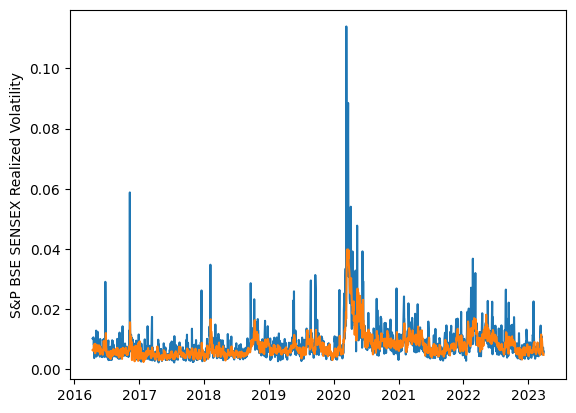

In [ ]:
plt.plot(forecasts["ds"], Y_true)
plt.plot(forecasts["ds"], Y_hat) 
plt.ylabel("S&P BSE SENSEX Realized Volatility")

# H=3 Forecasts

In [ ]:
Accuracy=[]
RMSE=[]
Quasilikelihood=[]
test_length=len(df["y"])-int(len(df['y'])*0.7)

In [ ]:
test_length%3

1

In [ ]:
for i in range(15):
  model = NBEATSx(h=3, input_size=63,
                  loss=MQLoss(level=[90]),
                  scaler_type='standard',
                  learning_rate= 0.0005,
                  stack_types=['trend','identity'],
                  n_blocks=[1,1],
                  mlp_units= [[512, 512], [512, 512]],
                  windows_batch_size=60,
                  num_lr_decays=5,
                  val_check_steps=100,
                  n_harmonics=0, n_polynomials=1,
                  hist_exog_list=['VIX'],
                  max_steps=200,
                  early_stop_patience_steps=1,
                  random_seed=randrange(129228148)
                  )
  fcst = NeuralForecast(models=[model],freq=Business_Days)
  forecasts = fcst.cross_validation(df=df,val_size=9,static_df=AirPassengersStatic,n_windows=None, test_size=test_length-test_length%3,step_size=3)
  forecasts = forecasts.dropna()
  if "NBEATSx-median" not in list(forecasts.columns.values):
    Y_hat=forecasts["NBEATSx"].values
  else:
    Y_hat=forecasts["NBEATSx-median"].values
  Y_true=forecasts["y"].values
  RMSE.append(np.sum(np.sqrt((Y_true-Y_hat)**2))/len(Y_true))
  Accuracy.append((1-np.sum(np.sqrt((Y_true-Y_hat)**2)/Y_true)/(len(Y_true)))*100)
  Quasilikelihood.append(np.sum(Y_true/Y_hat-np.log(Y_true/Y_hat)-1)/len(Y_true))

INFO:lightning_fabric.utilities.seed:Global seed set to 67109442


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 121994591


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 33189152


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 19376916


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 105555815


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 120926906


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 71435533


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 3428958


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 41357671


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 121090042


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

In [ ]:
RMSE

[0.0027216515414156127,
 0.0026629652840624053,
 0.0026935671847709884,
 0.0026820577277725252,
 0.002731193492426608,
 0.002709633351217712,
 0.002686339005459464,
 0.002703198238595917,
 0.002688033504034574,
 0.002705979447523775,
 0.0027172716699577406,
 0.0027408139991535077,
 0.0026908276598480987,
 0.002722110306200592,
 0.0027055469091520267]

In [ ]:
Accuracy

[69.26302564300184,
 70.14977948537535,
 69.99847699076489,
 69.83255899177819,
 69.0320688478813,
 69.03938890558834,
 69.79671570333183,
 69.74865911593709,
 69.75838619800562,
 70.03175473498656,
 68.93473480492726,
 68.97805616988676,
 69.87080946932582,
 69.35527766046533,
 69.12588117483737]

In [ ]:
Quasilikelihood

[0.08940583416240862,
 0.08813535373676167,
 0.0910801252872962,
 0.08814062292526942,
 0.08866186790234346,
 0.08649208067125469,
 0.08876550462772802,
 0.0925582436385812,
 0.08832350439885846,
 0.08950755730548574,
 0.08790677986464907,
 0.08963533614427795,
 0.09219781055123187,
 0.09122007596837726,
 0.0880117328470338]

Text(0, 0.5, 'S&P BSE SENSEX Realized Volatility')

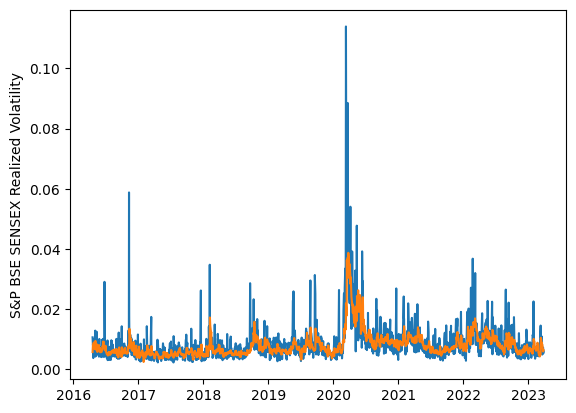

In [ ]:
plt.plot(forecasts["ds"], Y_true)
plt.plot(forecasts["ds"], Y_hat) 
plt.ylabel("S&P BSE SENSEX Realized Volatility")

# H=5 Forecasts

In [17]:
Accuracy=[]
RMSE=[]
Quasilikelihood=[]

In [18]:
for i in range(15):
  model = NBEATSx(h=5, input_size=63,
                  loss=MQLoss(level=[90]),
                  scaler_type='standard',
                  learning_rate= 0.0005,
                  stack_types=['trend','identity'],
                  n_blocks=[1,1],
                  mlp_units= [[512, 512], [512, 512]],
                  windows_batch_size=60,
                  num_lr_decays=5,
                  val_check_steps=100,
                  n_harmonics=0, n_polynomials=1,
                  hist_exog_list=['VIX'],
                  max_steps=200,
                  early_stop_patience_steps=1,
                  random_seed=randrange(129228148)
                  )
  fcst = NeuralForecast(models=[model],freq=Business_Days)
  forecasts = fcst.cross_validation(df=df,val_size=10,static_df=AirPassengersStatic,n_windows=None, test_size=test_length-test_length%5,step_size=5)
  forecasts = forecasts.dropna()
  if "NBEATSx-median" not in list(forecasts.columns.values):
    Y_hat=forecasts["NBEATSx"].values
  else:
    Y_hat=forecasts["NBEATSx-median"].values
  Y_true=forecasts["y"].values
  RMSE.append(np.sum(np.sqrt((Y_true-Y_hat)**2))/len(Y_true))
  Accuracy.append((1-np.sum(np.sqrt((Y_true-Y_hat)**2)/Y_true)/(len(Y_true)))*100)
  Quasilikelihood.append(np.sum(Y_true/Y_hat-np.log(Y_true/Y_hat)-1)/len(Y_true))

INFO:lightning_fabric.utilities.seed:Global seed set to 97693242


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 120389153


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 47264039


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 126042535


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 9185706


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 22172797


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 80724997


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 8749210


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 32205346


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 78353257


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 108040982


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 83724514


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 3619375


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 75885191


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 52567415


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

In [19]:
RMSE

[0.002744658318498207,
 0.002697081145543421,
 0.0027398336009801477,
 0.0027381641149602028,
 0.002724125802841587,
 0.0027735084003040773,
 0.0027153245858159676,
 0.0027158485633941016,
 0.002737613985827661,
 0.00274425503423647,
 0.0027021244616909743,
 0.0027260390866214947,
 0.0027153005548362415,
 0.002735936057937569,
 0.0027545975888630396]

In [20]:
Accuracy

[69.30061129725705,
 70.09740752866158,
 69.36246364600802,
 68.96445109309458,
 69.37703451577799,
 68.45069516006528,
 69.59280589700647,
 69.34692842257193,
 69.42869753108542,
 69.69634716811493,
 69.69185237485198,
 69.70546082927265,
 69.45002627502707,
 69.46853007543922,
 68.75586602778694]

In [21]:
Quasilikelihood

[0.09443811142712474,
 0.09585202337372976,
 0.09499741710760089,
 0.09443523183355529,
 0.09458113966317057,
 0.09417779814370304,
 0.09552396128083059,
 0.09505374746066082,
 0.09689871739769285,
 0.0976952206073592,
 0.09656970339597258,
 0.09515410276385061,
 0.09470152385698796,
 0.09672747404372123,
 0.09678810642009554]

Text(0, 0.5, 'S&P BSE SENSEX Realized Volatility')

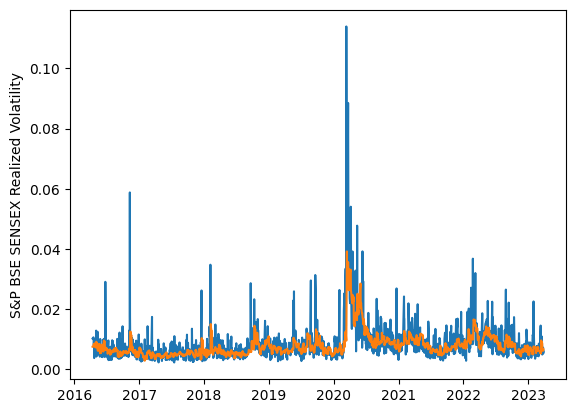

In [22]:
plt.plot(forecasts["ds"], Y_true)
plt.plot(forecasts["ds"], Y_hat) 
plt.ylabel("S&P BSE SENSEX Realized Volatility")

# H=10 Forecasts

In [23]:
Accuracy=[]
RMSE=[]
Quasilikelihood=[]

In [24]:
for i in range(15):
  model = NBEATSx(h=10, input_size=63,
                  loss=MQLoss(level=[90]),
                  scaler_type='standard',
                  learning_rate= 0.0005,
                  stack_types=['trend','identity'],
                  n_blocks=[1,1],
                  mlp_units= [[512, 512], [512, 512]],
                  windows_batch_size=60,
                  num_lr_decays=5,
                  val_check_steps=100,
                  n_harmonics=0, n_polynomials=1,
                  hist_exog_list=['VIX'],
                  max_steps=200,
                  early_stop_patience_steps=1,
                  random_seed=randrange(129228148)
                  )
  fcst = NeuralForecast(models=[model],freq=Business_Days)
  forecasts = fcst.cross_validation(df=df,val_size=10,static_df=AirPassengersStatic,n_windows=None, test_size=test_length-test_length%10,step_size=10)
  forecasts = forecasts.dropna()
  if "NBEATSx-median" not in list(forecasts.columns.values):
    Y_hat=forecasts["NBEATSx"].values
  else:
    Y_hat=forecasts["NBEATSx-median"].values
  Y_true=forecasts["y"].values
  RMSE.append(np.sum(np.sqrt((Y_true-Y_hat)**2))/len(Y_true))
  Accuracy.append((1-np.sum(np.sqrt((Y_true-Y_hat)**2)/Y_true)/(len(Y_true)))*100)
  Quasilikelihood.append(np.sum(Y_true/Y_hat-np.log(Y_true/Y_hat)-1)/len(Y_true))

INFO:lightning_fabric.utilities.seed:Global seed set to 43930034


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 4186065


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 113141407


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 42884202


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 92016081


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 56539697


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 62532096


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 30010823


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 64502940


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 70799902


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 39319513


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 24031369


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 127923513


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 71255360


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 78948343


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

In [25]:
RMSE

[0.0028134643632597325,
 0.0028013289128382213,
 0.002831416621249152,
 0.0028252048115095974,
 0.0028653235967355394,
 0.0028445323056405405,
 0.002855317353038423,
 0.0027999924918052973,
 0.002837828200350358,
 0.0028664333425036216,
 0.002847780348101939,
 0.0028025960422203033,
 0.0028253680455559535,
 0.0028507796235525402,
 0.002840900291996447]

In [26]:
Accuracy

[68.93611911774211,
 69.37467621057338,
 68.49486327694625,
 68.81466202884714,
 67.98014996854755,
 68.60838442650507,
 67.95417055489395,
 69.03374154264192,
 68.76940703396481,
 68.05948126611008,
 68.93892223636828,
 68.85236615919719,
 69.062019568598,
 68.44846393265492,
 67.65353464639774]

In [27]:
Quasilikelihood

[0.10225460744326097,
 0.10605033208192788,
 0.10438102140072524,
 0.10313680606087143,
 0.10513019158648239,
 0.10428326998841832,
 0.10476067128377554,
 0.10350308509331921,
 0.10392788875513188,
 0.106995312607084,
 0.10787179056807683,
 0.10233268542772181,
 0.10366265822022468,
 0.10356798212395917,
 0.10107923460828785]

Text(0, 0.5, 'S&P BSE SENSEX Realized Volatility')

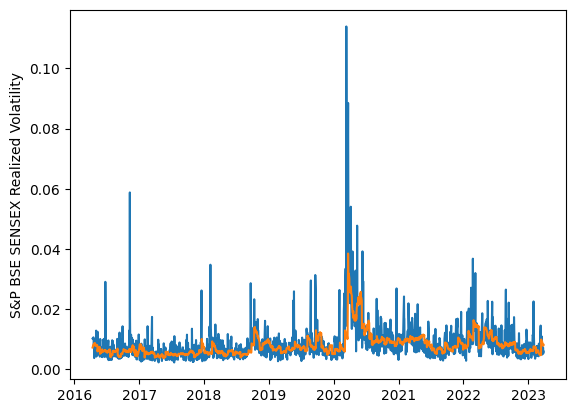

In [28]:
plt.plot(forecasts["ds"], Y_true)
plt.plot(forecasts["ds"], Y_hat) 
plt.ylabel("S&P BSE SENSEX Realized Volatility")

# H=22 Forecasts

In [29]:
Accuracy=[]
RMSE=[]
Quasilikelihood=[]

In [30]:
for i in range(15):
  model = NBEATSx(h=22, input_size=63,
                  loss=MQLoss(level=[90]),
                  scaler_type='standard',
                  learning_rate= 0.0005,
                  stack_types=['trend','identity'],
                  n_blocks=[1,1],
                  mlp_units= [[512, 512], [512, 512]],
                  windows_batch_size=60,
                  num_lr_decays=5,
                  val_check_steps=100,
                  n_harmonics=0, n_polynomials=1,
                  hist_exog_list=['VIX'],
                  max_steps=200,
                  early_stop_patience_steps=1,
                  random_seed=randrange(129228148)
                  )
  fcst = NeuralForecast(models=[model],freq=Business_Days)
  forecasts = fcst.cross_validation(df=df,val_size=22,static_df=AirPassengersStatic,n_windows=None, test_size=test_length-test_length%22,step_size=22)
  forecasts = forecasts.dropna()
  if "NBEATSx-median" not in list(forecasts.columns.values):
    Y_hat=forecasts["NBEATSx"].values
  else:
    Y_hat=forecasts["NBEATSx-median"].values
  Y_true=forecasts["y"].values
  RMSE.append(np.sum(np.sqrt((Y_true-Y_hat)**2))/len(Y_true))
  Accuracy.append((1-np.sum(np.sqrt((Y_true-Y_hat)**2)/Y_true)/(len(Y_true)))*100)
  Quasilikelihood.append(np.sum(Y_true/Y_hat-np.log(Y_true/Y_hat)-1)/len(Y_true))

INFO:lightning_fabric.utilities.seed:Global seed set to 8329329


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 68324562


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 100486141


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 23187565


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 87754127


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 30849205


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 110960593


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 1278895


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 15357612


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 14994856


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 124334489


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 40820725


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 16372552


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 3499275


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 21583660


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

In [31]:
RMSE

[0.0029375212373855225,
 0.0029546417959675692,
 0.0029569128027333086,
 0.002925114413835671,
 0.002912712099476475,
 0.0029461970996310332,
 0.0029163082316994034,
 0.0029511719787521646,
 0.0029648178258134313,
 0.0029737640428097027,
 0.0029717179189426668,
 0.0029520326465050863,
 0.0029797803941308838,
 0.002934141227724711,
 0.0029620232636250092]

In [32]:
Accuracy

[68.15134930216485,
 68.27027508834078,
 68.49073462203225,
 68.71432853651005,
 68.16335474561946,
 67.73904507246824,
 68.66626476878763,
 67.52606309829018,
 67.94195979470503,
 67.66395408306609,
 67.83618676638834,
 68.18631446584592,
 67.8784894731328,
 68.13986786655039,
 67.61091083231236]

In [33]:
Quasilikelihood

[0.13779706161277525,
 0.14650230270160622,
 0.145753834581233,
 0.1390399814136687,
 0.1339767375604566,
 0.13242171767421615,
 0.13530551304983218,
 0.13600089945812105,
 0.1375040153388853,
 0.1433210184026929,
 0.14525866819063027,
 0.14270537425002597,
 0.13839125512148293,
 0.13542473962253437,
 0.13745793472814818]

Text(0, 0.5, 'S&P BSE SENSEX Realized Volatility')

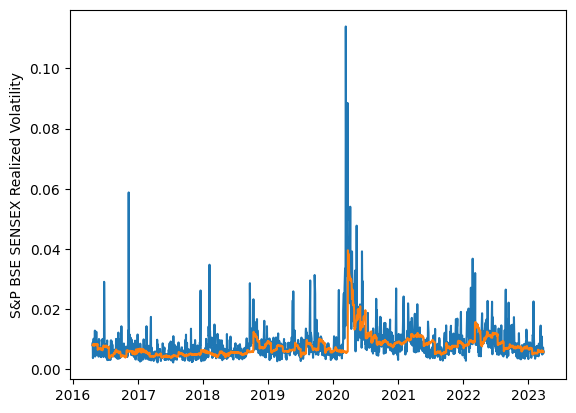

In [34]:
plt.plot(forecasts["ds"], Y_true)
plt.plot(forecasts["ds"], Y_hat) 
plt.ylabel("S&P BSE SENSEX Realized Volatility")